# Downloading AOD Data from NASA MODIS before and after the 2015 earthquake 
This Jupyter notebook defines several classes and functions to first scrape all MODIS AOD data over a certain time period, isolate a certain area, then download and write to a CSV file the AOD data over the Kathmandu Valley in Nepal. 

This notebook only scrapes the data and identifies locations. It does not do any analyis. 
# 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

import gdal
import requests

import os

# Class to Pull the NASA MODIS data and evaluate the output : AOD_Analysis

In [151]:
#Creates an object which pulls the data surrounding a given grid point.
#date is the date, which needs to be a string formatted like 'YYYY-MM-DD', or it will not work. 

class AOD_Analysis:
    def __init__(self,date,lat, lon, size):
        #This is the no data value, which replaces 9999 with a different value
        #making plotting easier
        self.nodataval=-.1
        #Load the file.
        #geo_data = pd.read_csv(filename)
        self.date = date
        self.all_geo_np = self.file_download_to_np()
        self.all_geo_np = np.where(self.all_geo_np > 999, self.nodataval, self.all_geo_np)
        self.trimmed_geo_np = self.trim_aod(lat,lon,size)
        self.lat=lat
        self.lon=lon
        self.centroid = f"{round(self.lat,2)}, {round(self.lon,2)}"
        #Count the number of eys data vs. no data
        nodata = np.where(self.trimmed_geo_np == self.nodataval, 1, 0).sum()
        yesdata = np.where(self.trimmed_geo_np == self.nodataval, 0, 1).sum()
        #Define an array just including np.nan, rather than nodataval
        usingnan = np.where(self.trimmed_geo_np == self.nodataval, np.nan, self.trimmed_geo_np)
        #Evaluate various statistics of the trimmed file, which is a key output.
        self.statistics = pd.DataFrame(data={
            "Date of 8-day Window":[self.used_date],
            "Centroid of Selection (Lat,Lon)":[self.centroid],
            "Number of Pixels":[self.trimmed_geo_np.shape[0]*self.trimmed_geo_np.shape[1]],
            "Average AOD":[np.nanmean(usingnan)],
            "5% Percentile AOD":[np.nanpercentile(usingnan,5)],
            "50% Percentile (Median) AOD":[np.nanpercentile(usingnan,50)],
            "95% Percentile AOD":[np.nanpercentile(usingnan,95)],
            "Percent of Pixels with no Data":[round(100*nodata/(self.trimmed_geo_np.shape[0]*self.trimmed_geo_np.shape[1]),2)]
        }
        )
        
    #Download the TIF file and conver to raster. 
    def file_download_to_np(self):
      
        #You need to check there is actually an 8-day file here.
        dates = [self.date]
        for day in np.arange(0,8):
            #FThere are only data files for once every 8 days. So, first, create an array of eight days following the date specififed.
            #This means that one and exactly one should have a data file. 
            date_check = pd.to_datetime(self.date).to_julian_date()
            date_check_2=date_check+day
            date1 =pd.to_datetime(date_check_2,origin='julian',unit='D')
            #Create the string, which means that you have to account for whether or not there should be a 0 value. 
            if date1.month <10: month = f'0{date1.month}'
            if date1.month >=10:  month = f'{date1.month}'
            if date1.day <10: day = f'0{date1.day}'
            if date1.day >=10:  day = f'{date1.day}'
            dater = f'{date1.year}-{month}-{day}'
            dates = dates + [dater]

        for usable_date in dates:
            urltest=f"https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_{usable_date}.FLOAT.TIFF"
            myfile = requests.get(urltest)
            #If the file actually exists, then download it. 
            if myfile.status_code == 200: 
                self.used_date=usable_date
                url = urltest
                print(f"File located for date {usable_date} at {url}!")
                break

        #Now define the filename and directory where it will be downloaded. 
        #Split and select the actual file's name. 
        dl_file_name=url.split('/')[-1]
        #Then add the directory name. 
        dir1 = 'data//temp//'
        file_dir=dir1+dl_file_name
        myfile = requests.get(url)
        #Now download it. 
        open(file_dir, 'wb').write(myfile.content)
        #Transform this to a raster file.
        raster = gdal.Open(file_dir)

        # Check type of the variable 'raster' and continue if it loads. 
        if (type(raster) == gdal.Dataset):
            print(f"Success! The TIF raster {file_dir} was successfully downloaded from {url}!")

            # Pull out the bands. There's only one MODIS datasets covering AOD. 
            band1 = raster.GetRasterBand(1) # This raster only has one channel. 
            #Then convert them to numpy aarrays.
            real_data = band1.ReadAsArray()  
            
        if (type(raster) != gdal.Dataset):
            sys.exit(f"Failure! The file could not be loaded to {file_dir} from {url}")    

        return(real_data)
    
    
    #Write a function to pull the cell in which the given latitude, longitude, is present. 
    #lat, lon are the coordinates. They must be in decimal degrees such that 90 N= 90 latitude, 90 S = -90, 180W = +180 longitude, etc.
    #res is the resolution (in degrees) of the file, defaulted to 0.1
    def find_cell(self,lat,lon, res=0.1):
        #Convert latitude/longitude to the right coordinates
        row_lat = -lat/res +90/res
        row_lon = lon/res + 180/res
        return int(row_lat),int(row_lon)
    
    #This function extracts the AOD centered on a given lat, lon
    #The lat,lon, are decimal latitude longtidue that will be the center of the grid point
    #size is the number of grid points to include
    def trim_aod(self,lat,lon,size):
        #Make the conversion
        lat_row,lon_row=self.find_cell(lat,lon)
        no_cells = int(size) 
        trimmed_aod = self.all_geo_np[(lat_row-no_cells):(lat_row+no_cells),(lon_row-no_cells):(lon_row+no_cells)]

        return trimmed_aod
    
    #Print chart
    #if trimmed=True, show only the trimmed version
    def show_map(self,trimmed=True):
        
        if trimmed != True:
            shower = self.all_geo_np
        if trimmed == True:
            shower = self.trimmed_geo_np
        plt.rcParams["figure.figsize"] = [8, 6]
        plt.rcParams["figure.autolayout"] = True
        im=plt.imshow(shower,cmap='copper')
        cbar = plt.colorbar(im)
        cbar.set_label(f"Aerosol Optical Depth Value ({self.nodataval} is no data)")
        plt.show()
    
    #Print histrogram of all values containing data
    #if trimmed=True, show only the trimmed version
    def show_hist(self,trimmed=True):
        if trimmed != True:
            shower = self.all_geo_np
        if trimmed == True:
            shower = self.trimmed_geo_np
            
        #shower = shower[shower < 999]
        fig,ax = plt.subplots(1,1)
        ax.hist(shower.ravel(),bins=100,density=False)
        ax.set_title(f"Histogram of AOD Centered on {round(self.lat,1)},{round(self.lon,1)} for 8 days near {self.used_date}")
        
        ax.set_xlabel(f'Aerosol Optical Depth ({self.nodataval} is no data)')
        ax.set_ylabel('Count')
        plt.show()

         

# Showing Examples of Retrieving Data near the brick kiln site
Below are some cells showing examples of using the AOD_Analysis class centered on the location of the brick kiln in Rupani, Nepal (26.23 lat, 86.73 lon)

File located for date 2015-04-23 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-04-23.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2015-04-23.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-04-23.FLOAT.TIFF!


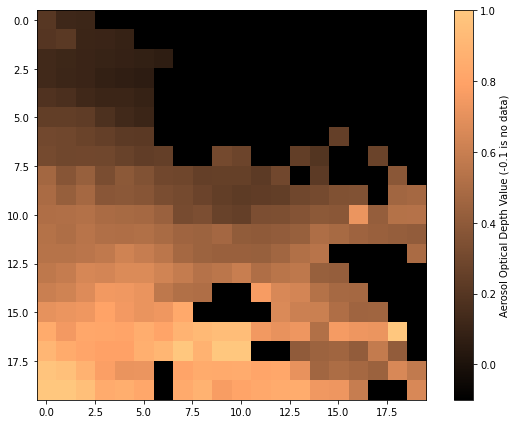

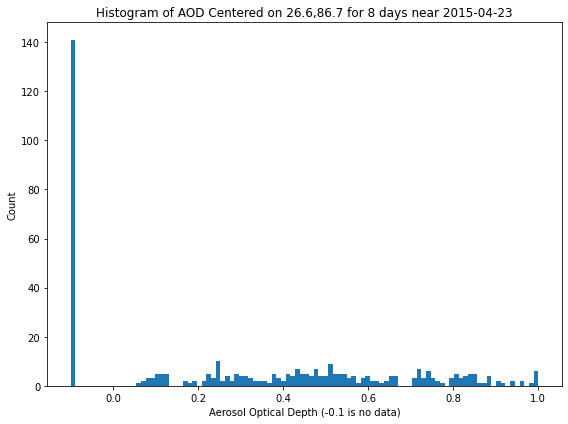

  Date of 8-day Window Centroid of Selection (Lat,Lon)  Number of Pixels  \
0           2015-04-23                    26.63, 86.73               400   

   Average AOD  5% Percentile AOD  50% Percentile (Median) AOD  \
0     0.503998           0.106299                     0.488189   

   95% Percentile AOD  Percent of Pixels with no Data  
0            0.901968                           54.44  


In [46]:
#Show a pixels degree size block
pixels = 10 #(1 degree for ar esolution of 0.1)
ruplat,ruplon=26.629722222222224,86.73083333333334
#Show the example of Rupani, Nepal, before the earthquake
rupani_before = AOD_Analysis('2015-04-20',ruplat,ruplon,pixels)
rupani_before.show_map()
rupani_before.show_hist()
print(rupani_before.statistics)

File located for date 2015-05-01 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-05-01.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2015-05-01.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-05-01.FLOAT.TIFF!


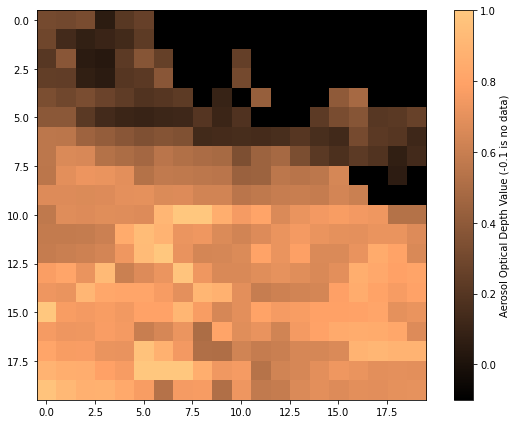

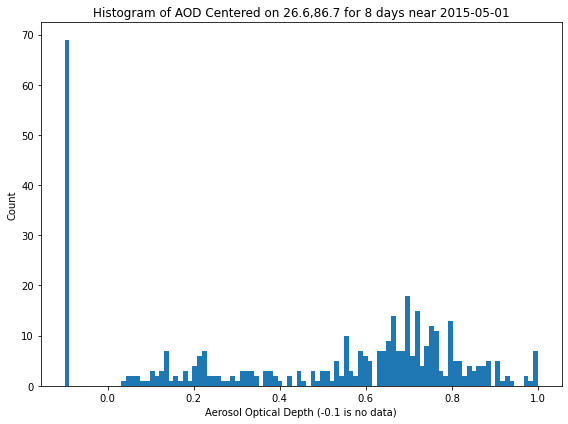

  Date of 8-day Window Centroid of Selection (Lat,Lon)  Number of Pixels  \
0           2015-05-01                    26.63, 86.73               400   

   Average AOD  5% Percentile AOD  50% Percentile (Median) AOD  \
0     0.590408            0.13189                     0.661417   

   95% Percentile AOD  Percent of Pixels with no Data  
0            0.903543                           20.85  


In [47]:
#Show the example of Rupani, Nepal, after the earthquake
rupani_after = AOD_Analysis('2015-05-1',ruplat,ruplon,pixels)
rupani_after.show_map()
rupani_after.show_hist()
print(rupani_after.statistics)

# Assessing AOD Changes Before and After the Earthquake Across the Kathmandu Valley
Let's now look at the whole country of Nepal. Did the earthquake measurably change the AOD across the region?
## Define a function to search a specific location over time. 

In [154]:
#Scan some time.
#startdate and endate are two strings in the form 'YYYY-MM-DD' which are the beginning and end of the searched time period
#lati,longi are the latitude and longitude to be centered upon.
#degree is the number of degrees on each side of the center point to include. The resolution is always 10 pixels per degree.
#Since the downloaded files are 
def scan_over_time(startdate,enddate,lati,longi,degrees=1):
    
    #The resolution of all the files downloaded is 0.1 degrees, so multiply by ten to get pixels.
    pixels=degrees*10
    #The pandas dataframe to be returned. 
    #vals = pd.DataFrame(columns=['Month','Average AOD'])

    initdate=pd.to_datetime(startdate).to_julian_date()
    enddate=pd.to_datetime(enddate).to_julian_date()
    all_dates=np.arange(initdate,enddate,7)
    datelist = []
    for date in all_dates:
        #Convert the julian date back to a normal date.
        date1 =pd.to_datetime(date,origin='julian',unit='D')
        #Create the string, which means that you have to account for whether or not there should be a 0 value. 
        if date1.month <10: interm = f'0{date1.month}'
        if date1.month >=10:  interm = f'{date1.month}'
        if date1.day <10: interd = f'0{date1.day}'
        if date1.day >=10:  interd = f'{date1.day}'
        dater = f'{date1.year}-{interm}-{interd}'
        
        datelist = datelist +[dater]
    vals = pd.DataFrame()
    for date in datelist:      

        inter = AOD_Analysis(date,ruplat,ruplon,pixels)
        print(f"Download and processing completed for for the MODIS AOD dataset centered on lat/lon {round(lati,1)}, {round(longi,1)} with the 8-day window ending on {date}')!")
        added = inter.statistics.copy(deep=True)
        
        vals = vals.append(added)
    
    x = np.asarray(vals['Date of 8-day Window'])
    data_1 = np.asarray(vals['Average AOD'])
    data_2 = np.asarray(vals['Percent of Pixels with no Data'])

    # Create Plot
    
    fig, ax1 = plt.subplots(figsize=(24,8)) 
    
    ax1.set_xlabel('Date of 8-Day Window') 
    ax1.set_ylabel('Aerosol Optical Depth') 
    plot_1=ax1.plot(x, data_1, color = 'brown',label="Average AOD across Area") 
    plt.ylim(0, 1)
    plt.axvline(x='2015-04-15', color='red', linestyle='--')
    
    plt.text('2015-04-15',.2,'Before\n Earthquake',horizontalalignment='center',bbox=dict(facecolor='white', alpha=1,edgecolor='black', boxstyle='square,pad=.5'))  
    plt.axvline(x='2015-04-23', color='red', linestyle='--')
    plt.text('2015-04-23',.1,'After\n Earthquake',horizontalalignment='center',bbox=dict(facecolor='white', alpha=1,edgecolor='black', boxstyle='square,pad=.5'))  
    
    # Adding Twin Axes
    ax2 = ax1.twinx() 
    plot_2=ax2.plot(x, data_2, color = 'orange',label="Percent of Pixels without Data")  
    plt.ylim(0, 100)

    # Add label
    plt.ylabel('Percent') 

    # Add legends
    plt.axvline(x='2015-04-23', color='red', linestyle='--')
    lns = plot_1 + plot_2
    labels = [l.get_label() for l in lns]
    plt.legend(lns, labels, loc=0)
    # Show plot
    
    plt.show()
    return vals

File located for date 2015-04-07 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-04-07.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2015-04-07.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-04-07.FLOAT.TIFF!
Download and processing completed for for the MODIS AOD dataset centered on lat/lon 26.6, 86.7 with the 8-day window ending on 2015-04-07')!
File located for date 2015-04-15 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-04-15.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2015-04-15.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2015-04-15.FLOAT.TIFF!
Download and processing completed for for the MODIS AOD dataset centered on lat/lon 26.6, 86.7 with the 8-day window ending on 2015-04-14')!
File located for dat

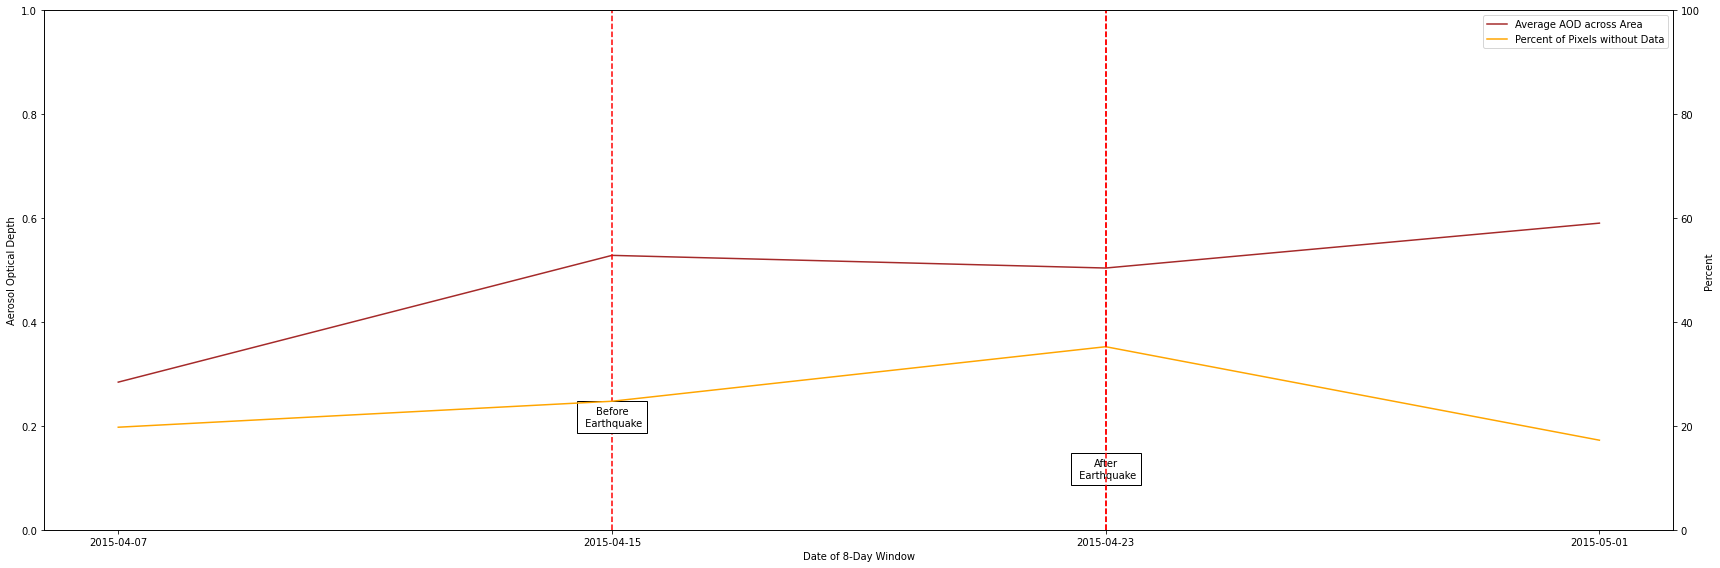

In [155]:
#Test run - does it work on the rupani coordinates?
rupani_data = scan_over_time('2015-04-07','2015-04-30',ruplat,ruplon)

## Now, do the Analysis on the Kathmandu Valley to see if a Change is Discernible
Inpsecting these maps:
https://www.researchgate.net/publication/332713605/figure/download/fig1/AS:752639306395649@1556454602314/Urbanizing-Nepal-showing-the-Kathmandu-Valley-in-the-set-map.png
https://www.mapsofworld.com/lat_long/maps/Nepal-lat-long.jpg
The center of Nepal is roughly at 28N, 84E.
Kathmandu (the city) is at 27.7N, 85.3 E longitude.
I culd not find a great map of the Kathmandu Valley, but it is roughly 50 kilometers in size from north to south and east to west. Ths is roughly 0.5 degrees longitude based on the NOAA calculator (https://www.nhc.noaa.gov/gccalc.shtml)
I will do an analyis with a radius of 0.5 degrees, which will capture the Valley. 
I will evaluate an extensive time period - 10 years - to ensure the full inter and intraannual variability is reflected in the data


File located for date 2010-01-01 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-01-01.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2010-01-01.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-01-01.FLOAT.TIFF!
Download and processing completed for for the MODIS AOD dataset centered on lat/lon 28, 84 with the 8-day window ending on 2010-01-01')!
File located for date 2010-01-09 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-01-09.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2010-01-09.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-01-09.FLOAT.TIFF!
Download and processing completed for for the MODIS AOD dataset centered on lat/lon 28, 84 with the 8-day window ending on 2010-01-08')!
File located for date 2010-0

C:\Users\TOBIAS~1.SCH\AppData\Local\Temp/ipykernel_10640/1373187432.py:28: RuntimeWarning: Mean of empty slice
  "Average AOD":[np.nanmean(usingnan)],
C:\Users\tobias.schultz\.conda\envs\geo_ds\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


File located for date 2010-07-04 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-07-04.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2010-07-04.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-07-04.FLOAT.TIFF!
Download and processing completed for for the MODIS AOD dataset centered on lat/lon 28, 84 with the 8-day window ending on 2010-07-02')!
File located for date 2010-07-12 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-07-12.FLOAT.TIFF!
Success! The TIF raster data//temp//MODAL2_E_AER_OD_2010-07-12.FLOAT.TIFF was successfully downloaded from https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-07-12.FLOAT.TIFF!
Download and processing completed for for the MODIS AOD dataset centered on lat/lon 28, 84 with the 8-day window ending on 2010-07-09')!
File located for date 2010-0

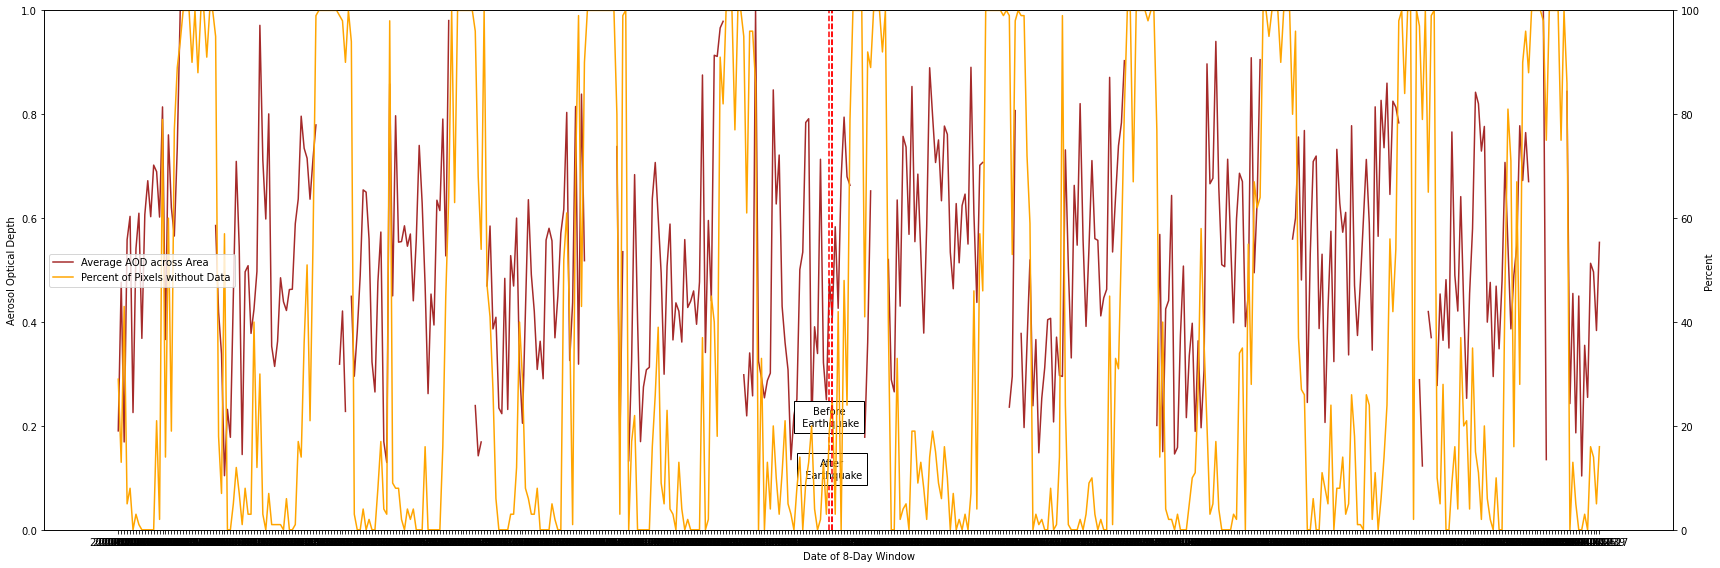

In [159]:
katlat,katlon=28,84
kat_data = scan_over_time('2010-01-01','2021-01-01',katlat,katlon,0.5)

# Write the output to a CSV file

In [162]:
print(kat_data.head())
kat_data.to_csv("data\\temp\\kathmandu_valley_8dayaod.csv")

  Date of 8-day Window Centroid of Selection (Lat,Lon)  Number of Pixels  \
0           2010-01-01                    26.63, 86.73               100   
0           2010-01-09                    26.63, 86.73               100   
0           2010-01-17                    26.63, 86.73               100   
0           2010-01-25                    26.63, 86.73               100   
0           2010-02-02                    26.63, 86.73               100   

   Average AOD  5% Percentile AOD  50% Percentile (Median) AOD  \
0     0.190474           0.059055                     0.145669   
0     0.476740           0.132283                     0.429134   
0     0.169084           0.092913                     0.141732   
0     0.558516           0.211417                     0.543307   
0     0.603432           0.332283                     0.624016   

   95% Percentile AOD  Percent of Pixels with no Data  
0            0.362205                            29.0  
0            1.000000             